# Assignment 4: Parameter Identification

### Goal
To find and optimize the stiffness and damping characteristics of our team's links based on length, apply these findings to the Pseudo-Rigid Body Model (PRBM) in simulation, and develop a generalized method for selecting model parameters based on physical dimensions (length) and model complexity (number of links) to accurately match real-world behavior.

### Experiment


The experiment was a dynamic cantilever beam experiment.
One side was fixed to the table through a weight, while the other had a mass on the end and was dropped to observe the oscillations. A strip of paper was placed on the end of the beam to place a marker on to allow for better motion tracking. A camera was placed on a steady tri-pod approximatley 3 feet away recording at 60fps 1080p to collect data.

<div style="text-align: center;">
  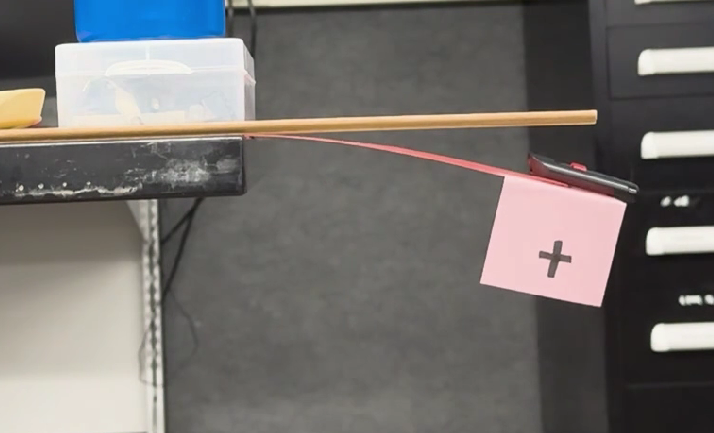
</div>

A 12 1/8 inch by 3 1/2 inch strip of cardstock was used for the beam. The length was changed by fixing more and more of the beam to the edge of the table and securing it with a weight. Dimensions and various lengths shown below. 

<div style="text-align: center;">
  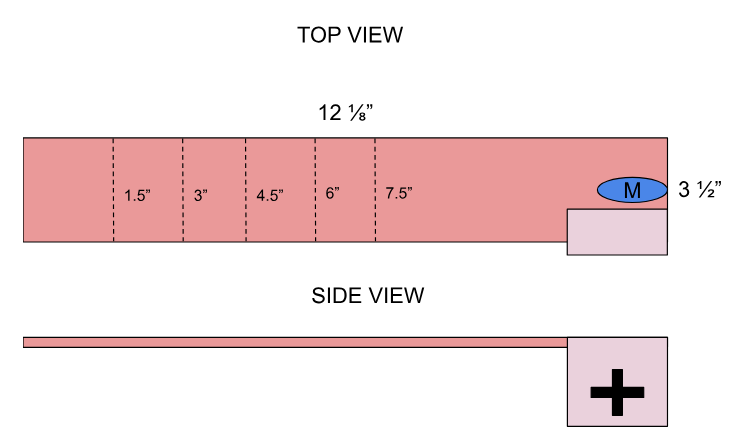
</div>

In total, ten trials were done. Five different lengths each with a different mass. The mass of the beam at each segment was calculated at the end, on a scale after cutting the fixed part off.
<div style="text-align: center;">
  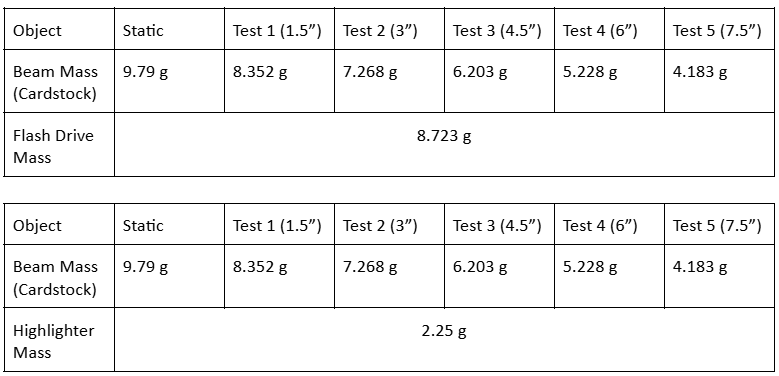
</div>

Motion tracking through free software - Tracker - was done fpr positional data over time. The process included cutting the video to regular oscillatory behavior, setting a coordinate axis, calibration stick, and point mass to track and correcting any miss-tracks. This data was then saved to an excel workbook, and used in the next section, Modeling.
<div style="text-align: center;">
  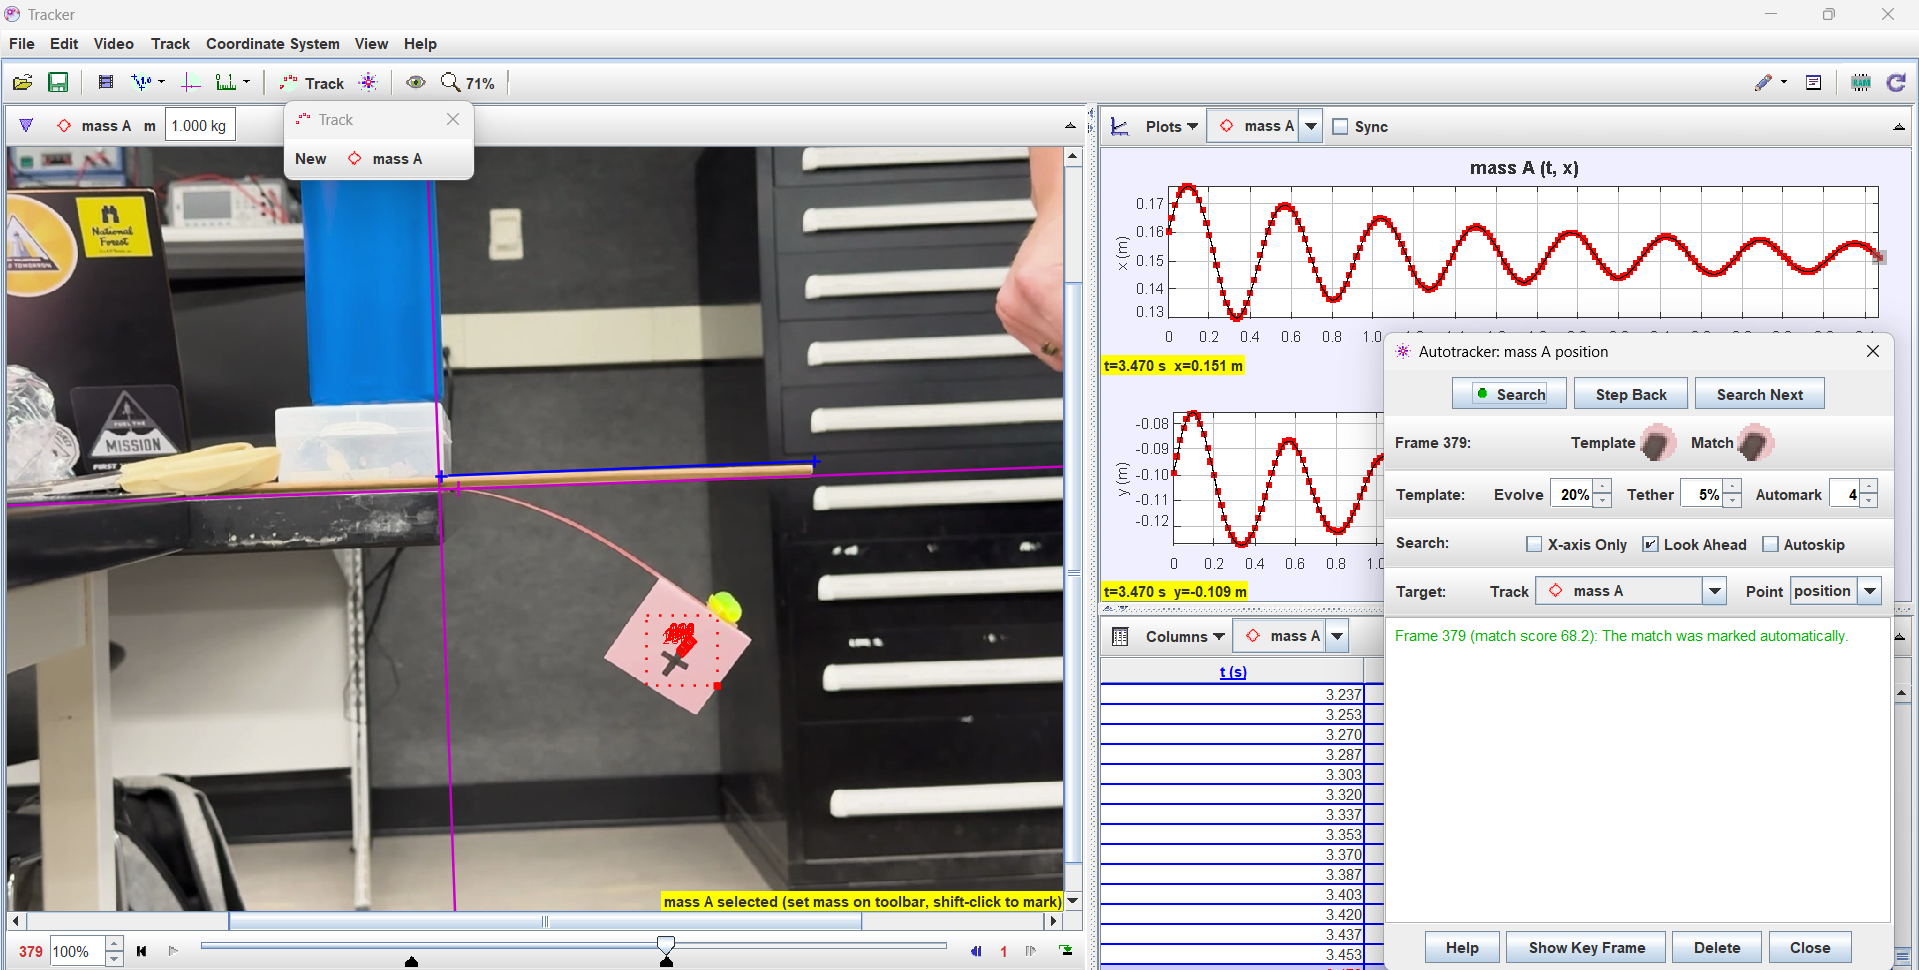
</div>

Here is a sample of the data collected:
\
\begin{array}{|c|c|c|}
\hline
t & x & y \\
\hline
0 & -0.0166 & -0.199 \\
0.0333 & -0.0178 & -0.198 \\
0.0667 & -0.013 & -0.201 \\
0.1 & -0.0012 & -0.208 \\
0.133 & 0.0171 & -0.214 \\
0.167 & 0.0327 & -0.216 \\
0.2 & 0.063 & -0.214 \\
0.233 & 0.0887 & -0.21 \\
0.267 & 0.113 & -0.202 \\
0.3 & 0.133 & -0.193 \\
\hline
\end{array}



### Modeling
A Pseudo-Rigid Body Model (PRBM) was used in Mujoco to represent the observed behavior of the system. This model was selected since it captures the nonlinear dynamics that arise in flexible structures. It is also especially useful in flexible robotics since we can easily change the number of links in our system to fit a desired stiffness or dampening value. 

First, let's pull in our experiment data and interpolate it:

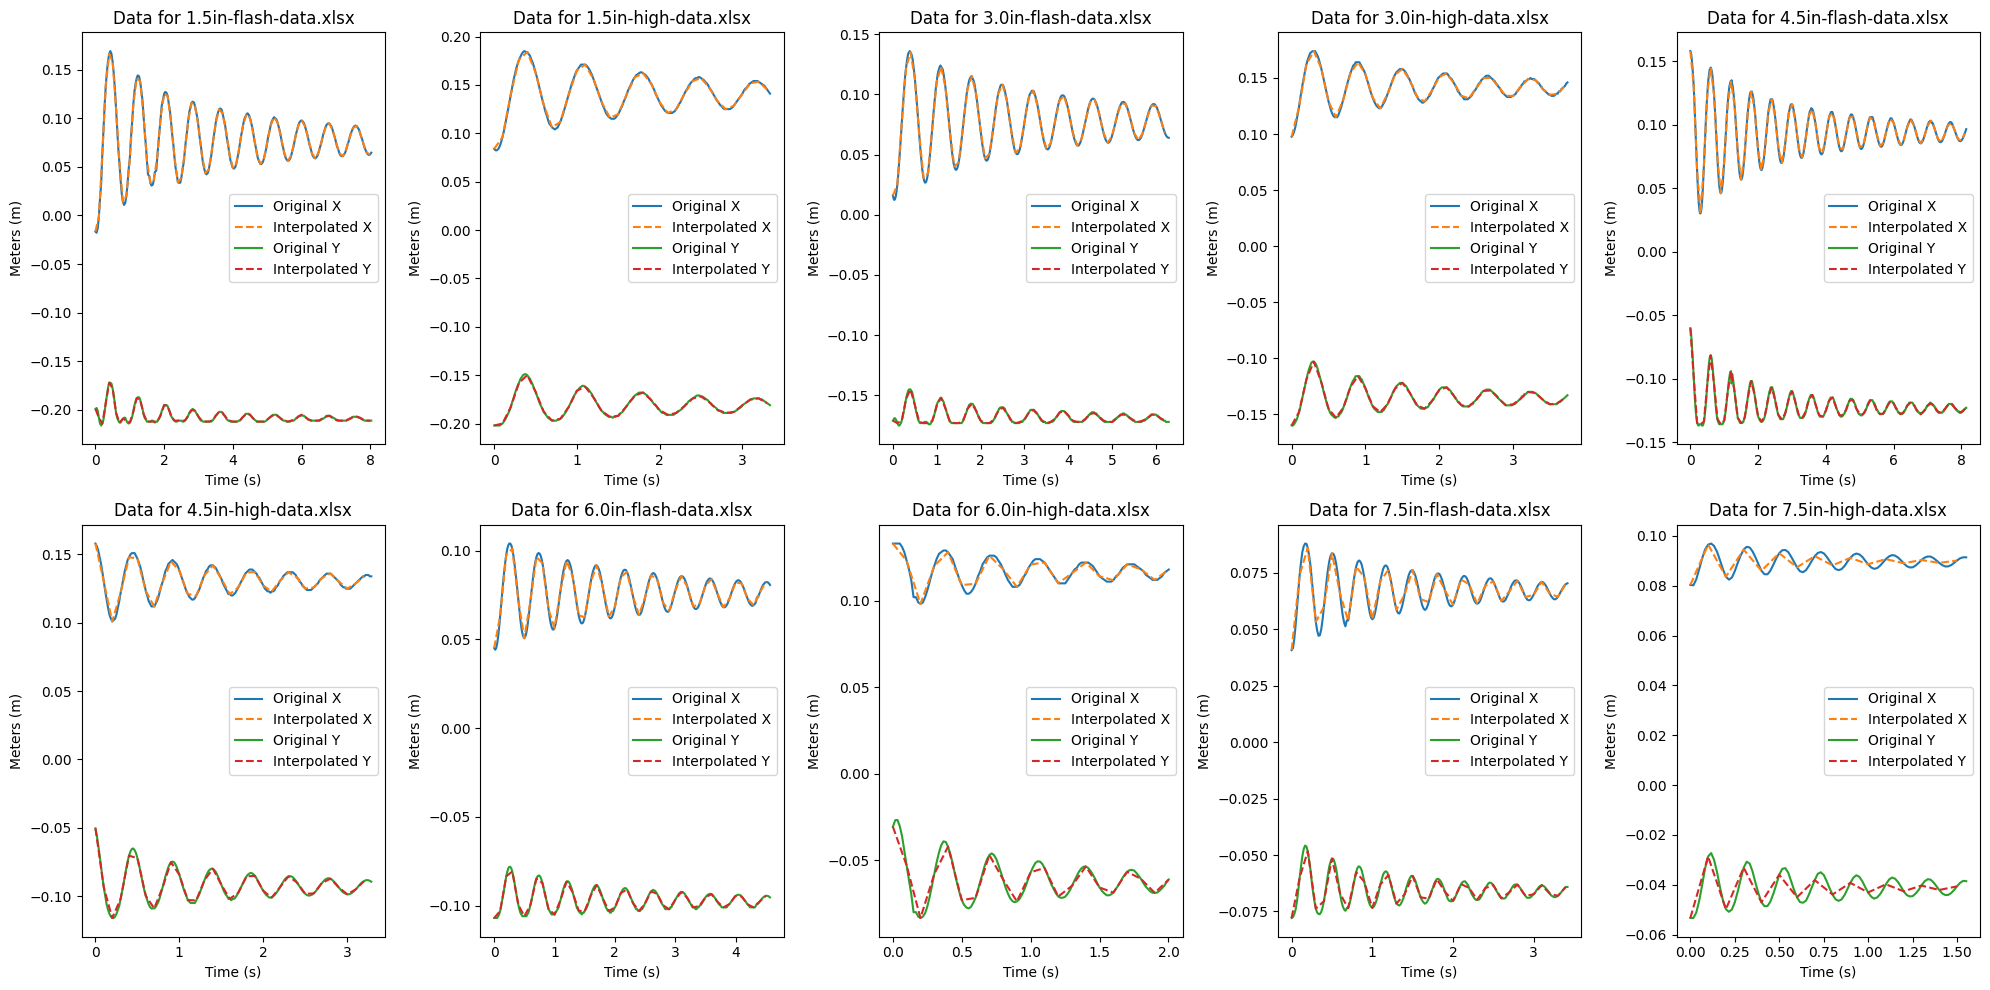

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
import scipy.interpolate as si

# Step 1: Load and preprocess experimental data from multiple files
def load_all_experimental_data(data_folder):
    interpolated_data = {}

    # Loop through each .xlsx file in the folder
    for filename in os.listdir(data_folder):
        if filename.endswith('.xlsx'):
            file_path = os.path.join(data_folder, filename)
            
            # Read the Excel file and convert to DataFrame
            df = pd.read_excel(file_path)
            
            # Convert DataFrame columns to numpy arrays
            t = df['t'].to_numpy()
            x = df['x'].to_numpy()
            y = df['y'].to_numpy()
            
            # Ensure `t` is sorted; if not, sort `t`, `x`, `y` arrays accordingly
            if not np.all(np.diff(t) > 0):
                sort_idx = np.argsort(t)
                t = t[sort_idx]
                x = x[sort_idx]
                y = y[sort_idx]
            
            # Interpolation
            xy = np.array([x, y]).T
            f = si.interp1d(t, xy.T, fill_value='extrapolate', kind='quadratic')
            new_t = np.arange(0, t[-1], 0.1)
            interpolated_xy = f(new_t)
            
            # Store both original and interpolated data
            interpolated_data[filename] = {
                't_original': t,
                'x_original': x,
                'y_original': y,
                't_interp': new_t,
                'x_interp': interpolated_xy[0],
                'y_interp': interpolated_xy[1]
            }
    
    return interpolated_data

# Step 2: Load data from the specified folder
data_folder = 'beam_data'  # Update with your folder path
all_data = load_all_experimental_data(data_folder)

# Step 3: Plotting original and interpolated data for all files
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, (filename, data) in enumerate(all_data.items()):
    if i >= len(axes):
        break  # Avoids index errors if there are more than 10 files
    
    ax = axes[i]
    # Plot original & interpolated data
    ax.plot(data['t_original'], data['x_original'], label="Original X")
    ax.plot(data['t_interp'], data['x_interp'], label="Interpolated X", linestyle="--")
    ax.plot(data['t_original'], data['y_original'], label="Original Y")
    ax.plot(data['t_interp'], data['y_interp'], label="Interpolated Y", linestyle="--")
    ax.set_title(f"Data for {filename}")
    ax.set_ylabel("Meters (m)")
    ax.set_xlabel("Time (s)")
    ax.legend()

plt.tight_layout()
plt.show()



Next, let's make our 3D model and make a function to run the simulation.

In [2]:
import mujoco
import numpy as np

main_template = """
<mujoco>
    <option><flag contact="disable"/></option>
    <worldbody>
        <light name="top" pos="0 0 1"/>
        <body name="body_1" pos="0 0 0">
            <joint name="joint_1" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="{k}"
                damping="{b}"/>
            <geom type="box" size="{l1_2} .05 .05" pos="{l1_2} 0 0" rgba="1 0 0 1" mass="{m}"/>
            {inner}
        </body>
    </worldbody>
</mujoco>
"""

body_template = '''
<body name="body_{ii}" pos="{l1} 0 0">
    <joint name="joint_{ii}" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="{k}"
        damping="{b}"/>
    <geom type="box" size="{l1_2} .05 .05" pos="{l1_2} 0 0" rgba="1 0 0 1" mass="{m}"/>
    {inner}
</body>
'''

test_point = '''
<geom type="sphere" size=".15" pos="{l1} 0 0" rgba="0 0 1 1" mass="1"/>
'''

def run_prbm_sim(num_links, k, b, m_total=1):
    """ Run the MuJoCo simulation with a given number of links, stiffness (k), and damping (b). """
    n_bodies = num_links
    length = 1  # Total length of the beam
    l_i = length / n_bodies
    m_i = m_total / n_bodies
    
    # Construct the MuJoCo XML model
    body_numbers = np.r_[n_bodies:1:-1]
    s = ''
    for item in body_numbers:
        if item == body_numbers.max():
            s = body_template.format(inner=test_point.format(l1='{l1}'), ii=item,
                                     l1='{l1}', l1_2='{l1_2}', b='{b}', k='{k}', m='{m}')
        else:
            s = body_template.format(inner=s, ii=item, l1='{l1}', l1_2='{l1_2}',
                                     b='{b}', k='{k}', m='{m}')
    
    s = main_template.format(inner=s, l1='{l1}', l1_2='{l1_2}', b='{b}', k='{k}', m='{m}')
    xml = s.format(l1=l_i, l1_2=l_i / 2, k=k, b=b, m=m_i)
    
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    
    # Simulation parameters
    duration = 3.0  # (seconds)
    framerate = 30  # (Hz)
    time_step = 1.0 / framerate
    num_steps = int(duration / time_step)
    
    t_sim = []
    xyz_sim = []
    
    mujoco.mj_resetData(model, data)
    
    prev_time = -1  # Initialize with a negative time to detect duplicates
    
    # Run the simulation
    for step in range(num_steps):
        mujoco.mj_step(model, data)
        
        current_time = data.time
        if current_time != prev_time:  # Ensure time progresses
            t_sim.append(current_time)
            xyz_sim.append(data.xpos[-1, :3])  # Track the position of the last link's endpoint
            prev_time = current_time
    
    # Convert lists to numpy arrays
    t_sim = np.array(t_sim)
    xyz_sim = np.array(xyz_sim)
    
    return t_sim, xyz_sim

Now, we want to calculate the error between the PRBM and the our cantilever beam experiment. We'll make a function we can reuse.

In [3]:
def calc_prbm_error(num_links, k, b, exp_t, exp_x, exp_y):
    t_sim, xyz_sim = run_prbm_sim(num_links, k, b, 18.513) # mass of first file
    
    # Check for duplicates in t_sim and handle them
    if len(np.unique(t_sim)) != len(t_sim):
        #print("Warning: Duplicate time values detected, removing duplicates.")
        unique_indices = np.unique(t_sim, return_index=True)[1]
        t_sim = t_sim[unique_indices]
        xyz_sim = xyz_sim[unique_indices, :]
    
    # Interpolate simulated data to match experimental time points
    f_sim_x = si.interp1d(t_sim, xyz_sim[:, 0], kind='quadratic', fill_value='extrapolate')
    f_sim_y = si.interp1d(t_sim, xyz_sim[:, 1], kind='quadratic', fill_value='extrapolate')
    sim_x = f_sim_x(exp_t)
    sim_y = f_sim_y(exp_t)
    
    # Calculate error (MSE) between experimental and simulated data
    mse_x = np.mean((exp_x - sim_x) ** 2)
    mse_y = np.mean((exp_y - sim_y) ** 2)
    return mse_x + mse_y

Now we will use that function to find the optimal link count that mimicks our motion from our experiment. For this I try 2-20 links.

Links: 2, Error: 0.15590438215684516
Links: 3, Error: 0.3118046914328123
Links: 4, Error: 0.410396566626565
Links: 5, Error: 0.4759087625399628
Links: 6, Error: 0.5220612373054004
Links: 7, Error: 0.5561461473013272
Links: 8, Error: 0.582269846361599
Links: 9, Error: 0.6028892618188744
Links: 10, Error: 0.6195540142896407
Links: 11, Error: 0.6332860166019703
Links: 12, Error: 0.6447849830678967
Links: 13, Error: 0.6545455128752746
Links: 14, Error: 0.6629268460235345
Links: 15, Error: 0.6701960773386794
Links: 16, Error: 0.6765558563318976
Links: 17, Error: 0.682162683092145
Links: 18, Error: 0.6871393169563447
Links: 19, Error: 0.691583391256241
Links: 20, Error: 0.6955735199284552


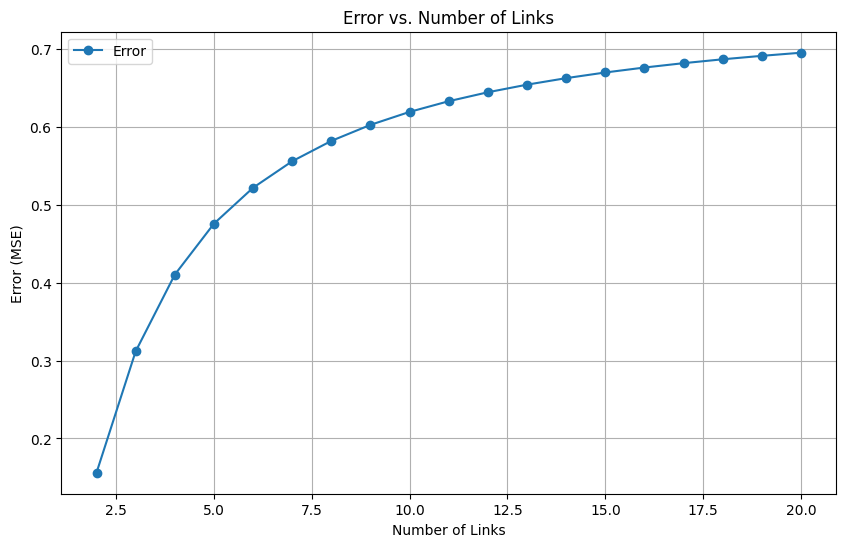

Optimal link count: 2.0, Minimum error: 0.15590438215684516


np.float64(2.0)

In [4]:
def find_optimal_link_count(exp_t, exp_x, exp_y, mass, k=50, b=0.5):
    """ Find the link count that best matches the experimental data. """
    link_counts = range(2, 21)  # Try different link counts from 2 to 20
    errors = []

    for num_links in link_counts:
        error = calc_prbm_error(num_links, k, b, exp_t, exp_x, exp_y)
        errors.append((num_links, error))
        print(f"Links: {num_links}, Error: {error}")

    # Convert results to numpy array for plotting
    errors = np.array(errors)

    # Plotting the error vs. link count
    plt.figure(figsize=(10, 6))
    plt.plot(errors[:, 0], errors[:, 1], marker='o', label='Error')
    plt.xlabel("Number of Links")
    plt.ylabel("Error (MSE)")
    plt.title("Error vs. Number of Links")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Find the optimal link count
    optimal_link_count, min_error = min(errors, key=lambda x: x[1])
    print(f"Optimal link count: {optimal_link_count}, Minimum error: {min_error}")
    return optimal_link_count

mass = 18.45 # first file
find_optimal_link_count(data['t_interp'], data['x_interp'], data['y_interp'], mass)

It looks like 2 links is actually more representative of our motion in the experiment. 

So now, let's use scipy optimize minimize to minimize the error and get the best k and b values for 2 links.

In [5]:
# Step 5: Optimize `k` and `b` for 2 links
def optimize_k_b(num_links, exp_t, exp_x, exp_y):
    def error_function(x):
        return calc_prbm_error(num_links, x[0], x[1], exp_t, exp_x, exp_y)
    
    initial_guess = [10, 0.1]
    bounds = ((1e-2, 1e3), (1e-3, 1e2))
    result = so.minimize(error_function, initial_guess, method='powell', bounds=bounds)
    
    # Unpack the optimized values for k and b
    k_opt, b_opt = result.x
    error = result.fun
    return k_opt, b_opt, error

exp_t = data['t_interp']
exp_x = data['x_interp']
exp_y = data['y_interp']

# Set the number of links to 2
num_links = 2

# Optimize k and b for 2 links
k_opt, b_opt, error = optimize_k_b(num_links, exp_t, exp_x, exp_y)

print(f"Links: {num_links}, Optimized k: {k_opt}, b: {b_opt}, Error: {error}")


Links: 2, Optimized k: 0.010000035531508383, b: 0.001048318437328773, Error: 0.1426022010290393


Now, let's see how this model performs compared to one of our experimental data sets:

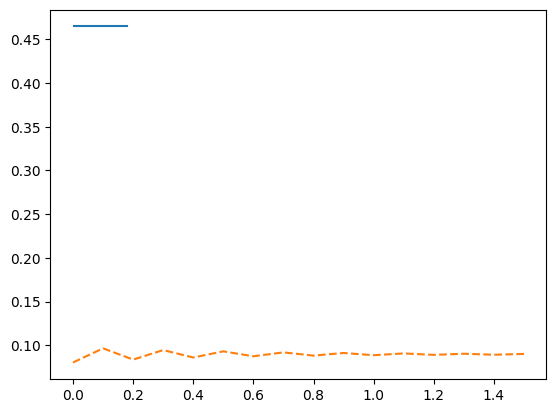

In [12]:
t_sim, xyz_sim = run_prbm_sim(2, k_opt, b_opt, 18.513)
x2_sim = xyz_sim.T[0]
plt.plot(t_sim, x2_sim, label="Simulated X")
plt.plot(data['t_interp'], data['x_interp'], label="Interpolated X", linestyle="--")

In [16]:
import mujoco
import numpy as np
import imageio
import os

# Your simulation function here
def run_prbm_sim(num_links, k, b, m_total=1):
    n_bodies = num_links
    length = 1  # Total length of the beam
    l_i = length / n_bodies
    m_i = m_total / n_bodies
    
    # Construct the MuJoCo XML model
    body_numbers = np.r_[n_bodies:1:-1]
    s = ''
    for item in body_numbers:
        if item == body_numbers.max():
            s = body_template.format(inner=test_point.format(l1='{l1}'), ii=item,
                                     l1='{l1}', l1_2='{l1_2}', b='{b}', k='{k}', m='{m}')
        else:
            s = body_template.format(inner=s, ii=item, l1='{l1}', l1_2='{l1_2}',
                                     b='{b}', k='{k}', m='{m}')
    
    s = main_template.format(inner=s, l1='{l1}', l1_2='{l1_2}', b='{b}', k='{k}', m='{m}')
    xml = s.format(l1=l_i, l1_2=l_i / 2, k=k, b=b, m=m_i)
    
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    
    # Simulation parameters
    duration = 3.0  # (seconds)
    framerate = 30  # (Hz)
    time_step = 1.0 / framerate
    num_steps = int(duration / time_step)
    
    t_sim = []
    xyz_sim = []
    
    mujoco.mj_resetData(model, data)
    
    prev_time = -1  # Initialize with a negative time to detect duplicates
    
    # Set up the viewer to render frames
    viewer = mujoco.MjViewer(model, data)
    
    # Run the simulation and capture frames
    frames = []
    for step in range(num_steps):
        mujoco.mj_step(model, data)
        
        current_time = data.time
        if current_time != prev_time:  # Ensure time progresses
            t_sim.append(current_time)
            xyz_sim.append(data.xpos[-1, :3])  # Track the position of the last link's endpoint
            prev_time = current_time
        
        # Render the current frame and capture it
        viewer.render()
        img = viewer.read_pixels(width=640, height=480, depth=False)[0]  # Capture frame
        frames.append(img)
    
    # Convert lists to numpy arrays
    t_sim = np.array(t_sim)
    xyz_sim = np.array(xyz_sim)
    
    return t_sim, xyz_sim, frames

def create_gif(frames, gif_filename="simulation_output.gif", duration=0.05):
    """Create a GIF from the simulation frames."""
    # Convert frames to an appropriate format for imageio
    imageio.mimsave(gif_filename, frames, duration=duration)

# Run the simulation
num_links = 5  # Example number of links in the beam
k = 1000  # Example stiffness value
b = 50  # Example damping value

t_sim, xyz_sim, frames = run_prbm_sim(num_links, k, b)

# Create the GIF from the frames
create_gif(frames, "simulation_output.gif")

print("GIF created successfully!")


AttributeError: module 'mujoco' has no attribute 'MjViewer'